In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext jupyter_black

import sys

sys.path.append("..")

from src.datautil import *
from src.modelutil import *
from src.trainutil import *
from src.metrics import *

import yaml

In [2]:
with open("../config.yaml", "r") as stream:
    cfg = yaml.safe_load(stream)

# Data Handling
load data, build vocab, build dataset and dataloader

In [3]:
data_root = "../data"
train_src_path = f"{data_root}/train.src"
train_tgt_path = f"{data_root}/train.tgt"

src_vocab, tgt_vocab = load_and_build_vocab(
    sentence_path=train_src_path,
    question_path=train_tgt_path,
    src_vocab_size=cfg["src_vocab_size"],
    tgt_vocab_size=cfg["tgt_vocab_size"],
)

print(len(src_vocab), len(tgt_vocab))

45000 28000


In [4]:
train_ds = SourceTargetDataset(
    data_dir=data_root,
    prefix="train",
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    src_max_seq=cfg["src_max_seq"],
    tgt_max_seq=cfg["tgt_max_seq"],
    return_tokenizers=True,
)

src_tokenizer = train_ds.src_tokenizer
tgt_tokenizer = train_ds.tgt_tokenizer

dev_ds = SourceTargetDataset(
    data_dir=data_root,
    prefix="dev",
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    src_max_seq=cfg["src_max_seq"],
    tgt_max_seq=cfg["tgt_max_seq"],
)

In [5]:
token_ids, _ = src_tokenizer.encode(["hello world"])
print(token_ids)
print(src_tokenizer.decode(token_ids))

tensor([[42571,    65]])
['hello world']


In [6]:
train_dl = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True)
valid_dl = DataLoader(dev_ds, batch_size=cfg["batch_size"], shuffle=False)

In [7]:
for src, tgt, src_mask, tgt_mask in train_dl:
    print(
        f"src: {src.shape}, tgt: {tgt.shape}, src_mask: {src_mask.shape}, tgt_mask: {tgt_mask.shape}"
    )
    break

src: torch.Size([64, 40]), tgt: torch.Size([64, 12]), src_mask: torch.Size([64, 40]), tgt_mask: torch.Size([64, 12])


# Misc Utils

In [8]:
def save_history(history, history_dir, save_graph=True):
    if not os.path.exists(history_dir):
        os.makedirs(history_dir)

    with open(f"{history_dir}/history.json", "w") as f:
        json.dump(history, f)

    if save_graph:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.plot(history["train/loss"], label="train/loss")
        ax.plot(history["valid/loss"], label="valid/loss")
        ax.legend()
        plt.savefig(f"{history_dir}/history_loss.png")

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.plot(history["valid/pplx"], label="valid/pplx")
        ax.legend()
        plt.savefig(f"{history_dir}/history_pplx.png")


def plot_attention(attention, src, tgt):
    src = src.split()[: attention.size(0)]
    tgt = tgt.split()

    fig, ax = plt.subplots(figsize=(20, 8))
    heatmap = ax.pcolor(attention.T.cpu(), cmap=plt.cm.Blues, alpha=0.9)

    xticks = range(0, len(src))
    ax.set_xticks(xticks, minor=False)  # major ticks
    ax.set_xticklabels(src, minor=False, rotation=45)  # labels should be 'unicode'

    yticks = range(0, len(tgt))
    ax.set_yticks(yticks, minor=False)
    ax.set_yticklabels(tgt, minor=False)  # labels should be 'unicode'

    ax.set_xlabel("source")
    ax.set_ylabel("target")

    ax.grid(False)

    # Save Figure
    plt.show()
    fig.savefig("attention.png")

# Model Building

In [9]:
cfg["experiment_name"] = "debug1"
checkpoint_dir = f"{cfg['checkpoint_dir']}/{cfg['experiment_name']}"
history_dir = f"{checkpoint_dir}/history"

model = Seq2Seq(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    src_embedding_vector=None,
    tgt_embedding_vector=None,
    tgt_pad_index=tgt_vocab["<PAD>"],
    tgt_sos_index=tgt_vocab["<SOS>"],
    tgt_eos_index=tgt_vocab["<EOS>"],
    hidden_size=cfg["hidden_size"],
    bidirectional=cfg["bidirectional"],
    num_layers=cfg["num_layers"],
    src_embedding_size=cfg["src_embedding_size"],
    tgt_embedding_size=cfg["tgt_embedding_size"],
    dropout=cfg["dropout"],
)

optimizer = torch.optim.SGD(
    model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"]
)


history = fit(
    model=model,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    cfg=cfg,
    checkpoint_dir=checkpoint_dir,
    max_step=-1,
    epoch=0,
    lr_scheduler=None,
    ignore_index=tgt_vocab["<PAD>"],
)

Training...
	Step: 0/1102, Loss: 10.258065223693848
	Step: 200/1102, Loss: 6.9334716796875
	Step: 400/1102, Loss: 6.736991882324219
	Step: 600/1102, Loss: 6.773270606994629
	Step: 800/1102, Loss: 6.64160680770874
	Step: 1000/1102, Loss: 6.5660905838012695
Validating...
	Step: 0/166, Loss: 6.511457920074463
	Step: 100/166, Loss: 6.39280891418457

🎉 best pplx reached, saved a checkpoint.

Epoch: 1,	Train Loss: 6.836642964132901,	Val Loss: 6.348591738436595	val pplx: 592.6773878350315
Training...
	Step: 0/1102, Loss: 6.579156398773193
	Step: 200/1102, Loss: 6.447241306304932
	Step: 400/1102, Loss: 6.517650604248047
	Step: 600/1102, Loss: 6.593564510345459
	Step: 800/1102, Loss: 6.502318859100342
	Step: 1000/1102, Loss: 6.509509563446045
Validating...
	Step: 0/166, Loss: 6.432368278503418
	Step: 100/166, Loss: 6.300520896911621

Epoch: 2,	Train Loss: 6.477587658783485,	Val Loss: 6.258967979844794	val pplx: 541.5825642045722
Training...
	Step: 0/1102, Loss: 6.57525634765625
	Step: 200/1102,

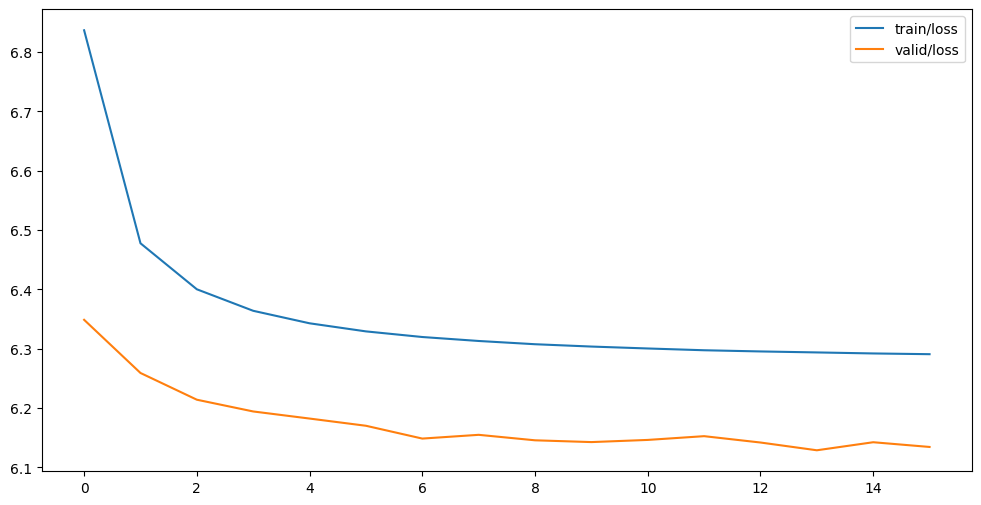

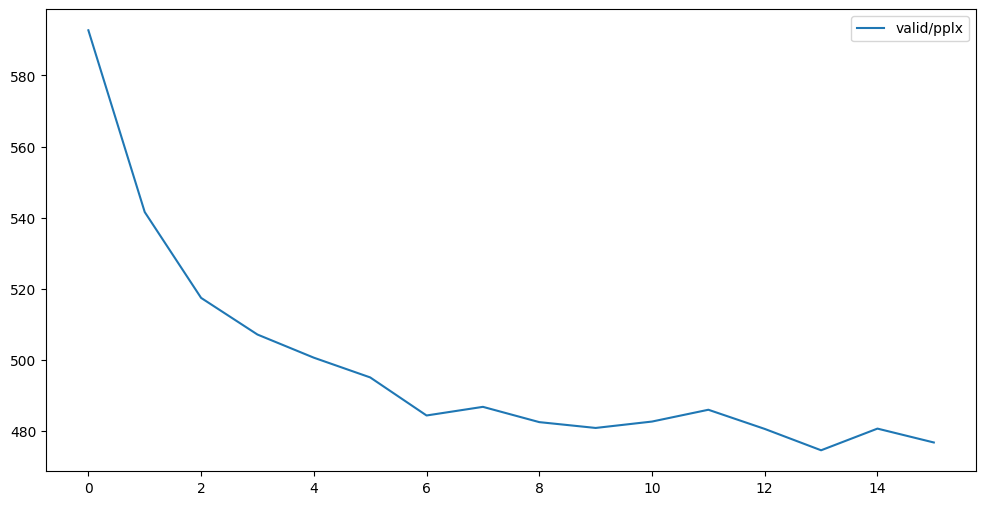

In [13]:
save_history(history, history_dir, save_graph=True)

# Generation & Visualization

hypothesis: 


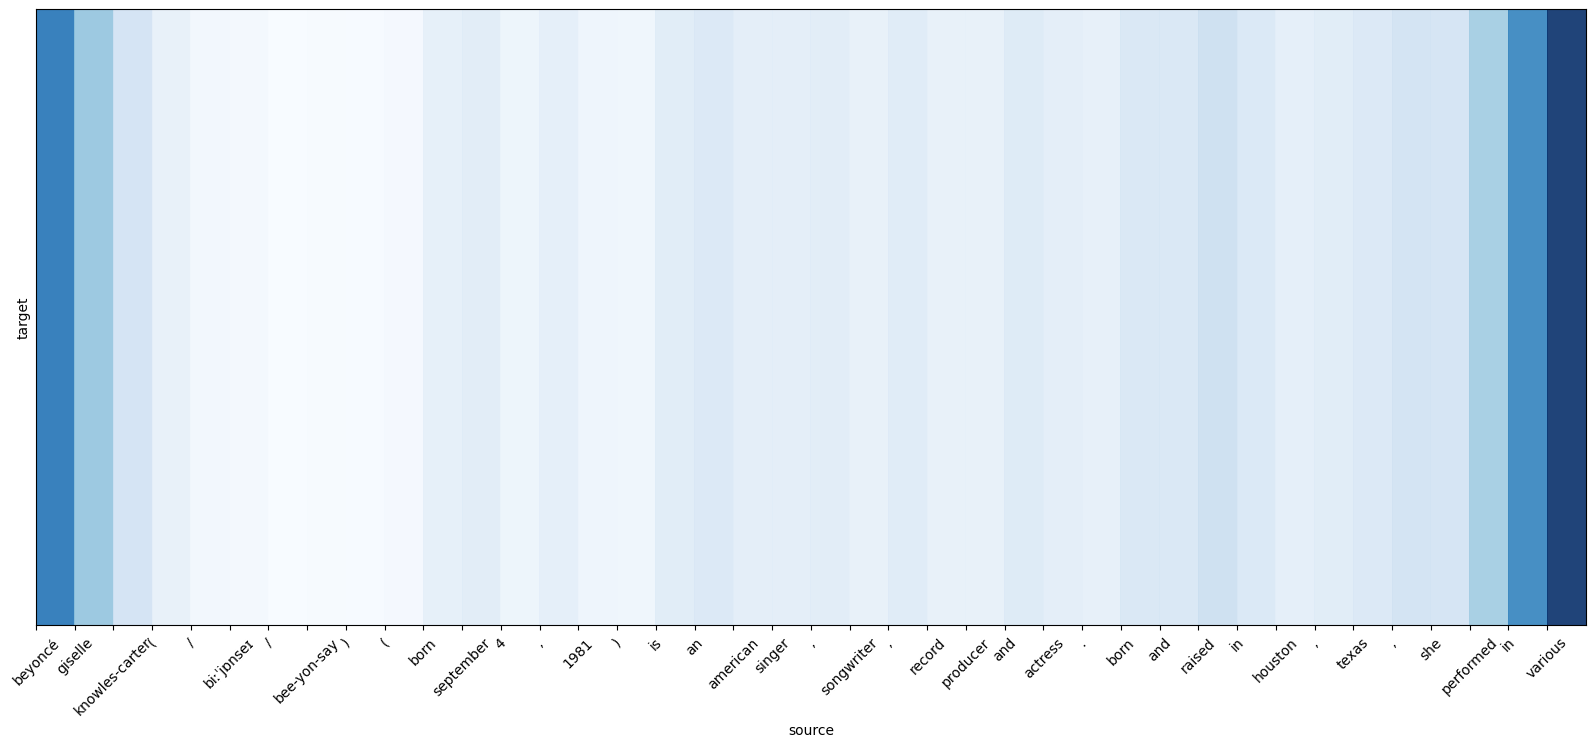

In [29]:
source = "beyoncé giselle knowles-carter ( / biːˈjɒnseɪ / bee-yon-say ) ( born september 4 , 1981 ) is an american singer , songwriter , record producer and actress . born and raised in houston , texas , she performed in various singing and dancing competitions as a child , and rose to fame in the late 1990s as lead singer of r &amp; b girl-group destiny &apos;s child . managed by her father , mathew knowles , the group became one of the world &apos;s best-selling girl groups of all time . their hiatus saw the release of beyoncé &apos;s debut album , dangerously in love ( 2003 ) , which established her as a solo artist worldwide , earned five grammy awards and featured the billboard hot 100 number-one singles &quot; crazy in love &quot; and &quot; baby boy &quot; ."
hyp, attn = generate(model, source, src_tokenizer, tgt_tokenizer, cfg, method="greedy")
print("hypothesis:", hyp[0])
plot_attention(attn.squeeze(0), source, hyp[0])

In [30]:
with open(f"{data_root}/dev.src") as srcfile:
    sources = srcfile.readlines()

with open(f"{data_root}/dev.tgt") as tgtfile:
    references = tgtfile.readlines()

hypotheses = []
for source in sources:
    hyp, _ = generate(model, source, src_tokenizer, tgt_tokenizer, cfg, method="greedy")
    hypotheses.append(hyp[0])

metrics = compute_metrics(hypotheses, references)
metrics = {k: v * 100 for k, v in metrics.items()}

In [31]:
metrics

{'bleu1': 0.0, 'bleu2': 0.0, 'bleu3': 0.0, 'bleu4': 0.0, 'rougeL': 0.0}